# Load data, train model

In [1]:
import sage
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [4]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=0.3,
                           depth=3)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

# LossSHAP cooperative game

In [5]:
from shapreg import removal, games, shapley
from shapreg.utils import crossentropyloss

In [6]:
# Make model callable
model_lam = lambda x: model.predict_proba(x)

# Model extension
marginal_extension = removal.MarginalExtension(train[:128], model_lam)

In [7]:
# Set up game (single prediction)
instance = test[0]
label = Y_test[0]
game = games.PredictionLossGame(marginal_extension, instance, label, crossentropyloss)

In [8]:
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32)

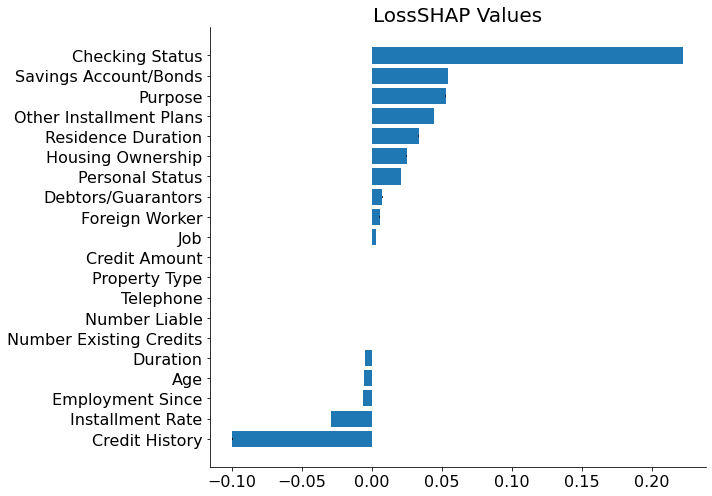

In [9]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='LossSHAP Values')

# SAGE cooperative game

In [10]:
from shapreg import stochastic_games

In [11]:
# Set up game (dataset loss)
game = stochastic_games.DatasetLossGame(marginal_extension, test, Y_test, crossentropyloss)

In [12]:
# Run estimator
explanation = shapley.ShapleyRegression(game)

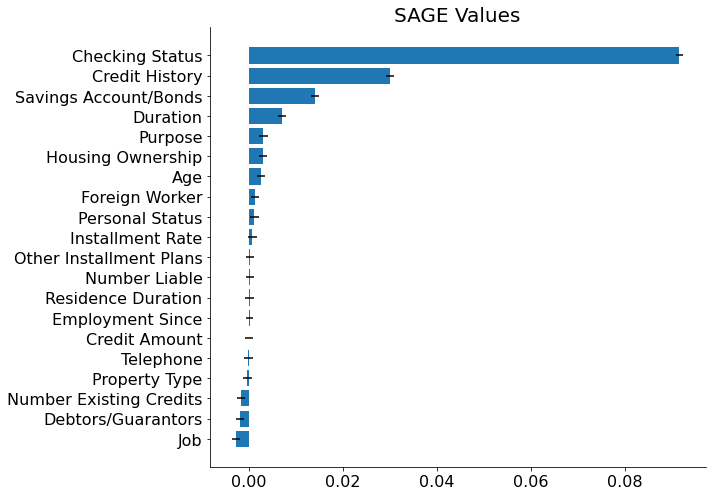

In [13]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='SAGE Values')